In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset

import torchvision as tv
import PIL.Image as Image

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\sokmo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.22.4 and <1.29.0 is required for this version of SciPy (detected version 1.22.0)
  from scipy.sparse import csr_matrix, issparse


The following dataset is from a kaggle competition: [Leaf Classification](https://www.kaggle.com/competitions/leaf-classification/overview)

> IMPORTANT

The dataset directory structure is modified.  Please update the img_dir and csv_dir to the correct form. Or modified your dataset directory into the form:

- `leaf-classification/`
    - `images/`
        - `1.jpg`
        - `...`
    - `test.csv`
    - `train.csv`

In [2]:
t.manual_seed(101)

img_dir = '../../datasets/leaf-classification/images/'
csv_dir = '../../datasets/leaf-classification/train.csv'

img_filenames_list = os.listdir(img_dir)
dataframe = pd.read_csv(csv_dir)
dataframe['species'] = dataframe['species'].astype('category').cat.codes
dataframe.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,3,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,49,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,65,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,94,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,84,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


# Two parts of the competition
1. Leaf classification using binary images
2. Leaf classification using numerical data included in the csv files

# Dataset
- 99 species of leaf
- `train.csv`: use to train and test the model
- `test.csv`: actual validation to generate the submission
- All 1584 `jpg` images are in `images/` without any speparation
- Images filename are `id.jpg`
- The class of each images can be found in the `train.csv` with its corresponding id under the `species` column

Due to the nature of this dataset, a custom `Dataset` class is required to easily load images and combine them with its corresponding label.

In [3]:
class LeafDataset(Dataset):
    def __init__(self, images_dir, dataframe, transform):
        self.images_dir = images_dir
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = str(int(self.dataframe.iloc[idx]['id'])) + ".jpg"
        img_dir = os.path.join(self.images_dir, img_name)

        # img = Image.open(img_dir)
        # read_image returns a tensor
        # no need for transforms.ToTensor()
        img = tv.io.read_image(img_dir)
        img = self.transform(img)
        label = self.dataframe.iloc[idx]['species']
        label = label.astype('int64')
        return img, label

In [4]:
dataframe['species'].value_counts()

3     10
26    10
2     10
39    10
0     10
      ..
12    10
88    10
27    10
36    10
91    10
Name: species, Length: 99, dtype: int64

In [6]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
BATCH_SIZE = 64
TEST_SIZE = 0.2
NUM_DATASET_REPEAT = 5 # repeat the dataset with augmentation to increase the number of samples

train_df, test_df = train_test_split(dataframe, test_size=TEST_SIZE)
len(train_df) * NUM_DATASET_REPEAT, len(test_df) * NUM_DATASET_REPEAT

(3960, 990)

In [19]:
train_transform = tv.transforms.Compose([
    tv.transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(90),
    tv.transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    tv.transforms.Lambda(lambda x: x/255.0), # normalize the image and to float
    # tv.transforms.ToTensor(), # using read_image already converts to tensor
])

test_transform = tv.transforms.Compose([
    tv.transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(90),
    tv.transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    tv.transforms.Lambda(lambda x: x/255.0), # normalize the image and to float
])  

train_ds = LeafDataset(img_dir, dataframe=train_df, transform=train_transform)
test_ds = LeafDataset(img_dir, dataframe=test_df, transform=test_transform)

# increase the size of the dataset by repeating the data 
# while augmenting each of them slightly differently
augmented_train_ds = ConcatDataset([train_ds for _ in range(NUM_DATASET_REPEAT)])
augmented_test_ds = ConcatDataset([test_ds for _ in range(NUM_DATASET_REPEAT)])

train_dl = DataLoader(augmented_train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(augmented_test_ds, batch_size=BATCH_SIZE, shuffle=True)

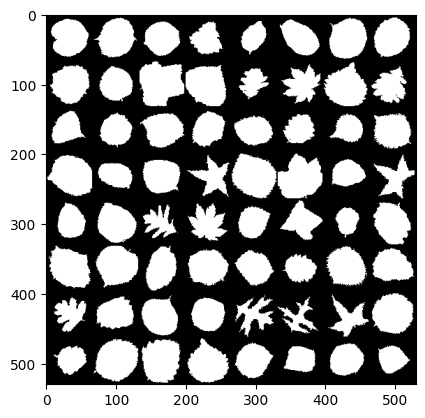

In [20]:
img, label = next(iter(train_dl))
# make a grid from batch
out = tv.utils.make_grid(img)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [21]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # original image size: 64 x 64
        self.conv1 = nn.Conv2d(1, 16, 3) # -> 62 x 62
        # max pool -> 31 x 31
        self.conv2 = nn.Conv2d(16, 32, 3) # -> 29 x 29
        # max pool again -> 14 x 14
        self.conv3 = nn.Conv2d(32, 32, 3) # -> 12 x 12
        # max pool again -> 6 x 6
        self.layer1 = nn.Linear(32 * 6 * 6, 128)
        self.layer2 = nn.Linear(128, 99)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = t.flatten(x, 1)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        # x = self.softmax(x)
        return x

In [22]:
def train(model, train_dl, loss_func, optimizer):
    model.train()
    total_loss = 0
    for i, (img, label) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        print(f"Batch: {i}/{len(train_dl)}, Loss: {loss.item()}", end='\r')
    return total_loss / len(train_dl)

def test(model, test_dl, loss_func):
    model.eval()
    total_loss = 0
    with t.no_grad():
        for i, (img, label) in enumerate(test_dl):
            output = model(img)
            loss = loss_func(output, label)
            total_loss += loss.item()
    return total_loss / len(test_dl)

def fit(model, train_dl, test_dl, loss_func, optimizer, epochs, callback):
    for epoch in range(epochs):
        train_loss = train(model, train_dl, loss_func, optimizer)
        test_loss = test(model, test_dl, loss_func)
        callback(epoch, train_loss, test_loss, model)

In [23]:
model = Model()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

model.load_state_dict(t.load('./models/model_2_45_more_conv.pth'))

<All keys matched successfully>

In [ ]:
epochs = 20
losses = []

def callback(epoch, train_loss, test_loss, model):
    print(f"Epoch: {epoch}, Train loss: {train_loss}, Test loss: {test_loss}")
    losses.append([epoch, train_loss, test_loss])
    model_path = f"./models/model_{epoch}.pth"
    t.save(model.state_dict(), model_path)

fit(model, 
    train_dl, 
    test_dl, 
    loss_func, 
    optimizer, 
    epochs, 
    callback)

losses = np.array(losses)
plt.title('Test Losses over Epochs')
plt.plot(losses[:, 0], losses[:, 2], label='test')